In [24]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

import matplotlib.pyplot as plt
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import pickle

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

%matplotlib inline

# Record Audio

In [25]:
def feature_extractor(sound_path, win_length_ms=25, hop_length_ms=10):
    # Load the audio file
    signal, sr = librosa.load(sound_path,sr=8000)
    # signal,sr = wavfile.read(sound_path)
    # Extract MFCCs
    win_length_samples = int(sr * win_length_ms / 1000)
    hop_length_samples = int(sr * hop_length_ms / 1000)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, hop_length=hop_length_samples, win_length=win_length_samples)
    # mfccs = mfcc(signal,samplerate=sr,nfft = 2048,numcep=13,nfilt=13)
    
    #Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features

In [26]:
def preprocess(path, is_pca=0, num_pca = 2, window_length_ms=20, hop_length_ms=10):
    '''
    Return the numpy array
    '''
    # Get the path of the audio file
    audio_file = Path(path)
    samples,sample_rate = librosa.load(audio_file,sr=8000)
    # print(f"The original samples are {samples.shape} and sample rate is {sample_rate}")
    # Remove silence at start and end
    # TODO: Apply VAD
    # samples_trimmed, _= librosa.effects.trim(samples, top_db=60)
    a, b, c, d = feature_extractor(audio_file,window_length_ms,hop_length_ms)
    # tot= np.concatenate((a,b,c,d)).T
    tot = d.T
          
    # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
    columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
    df = pd.DataFrame(tot, columns=columns)

    # Save the DataFrame to a CSV file
    #csv_filename = '{path}.csv'
    #df.to_csv(csv_filename, index=False)
    
    if(is_pca==1):
        pca = PCA(n_components=num_pca)
        components = pca.fit_transform(df)
        df = pd.DataFrame(data=components)
    df_new = df.to_numpy()
    return df_new

In [27]:
def preprocess_folder(folder_path, is_pca=0, num_pca=2, items=50,window_length_ms=20, hop_length_ms=10):
    '''
    Return a numpy array containing preprocessed data from all .wav files in the specified folder.
    '''
    # Initialize an empty list to store data from all files
    data_list = []
    i = 0
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        if(i>items):
            break
        # Check if the file is a .wav file
        if file_name.endswith('.wav'):
            # Get the full path of the audio file
            audio_file = os.path.join(folder_path, file_name)
            # samples, sample_rate = librosa.load(audio_file, sr=16000)
            #print(f"Processing {audio_file}: original samples are {samples.shape} and sample rate is {sample_rate}")

            # Remove silence at start and end
            # samples_trimmed, _ = librosa.effects.trim(samples, top_db=60)
            a, b, c, d = feature_extractor(audio_file)
            # tot = np.concatenate((a, b, c, d)).T
            tot = d.T

            # Create a DataFrame with column names as MFCC_1, MFCC_2, etc.
            columns = [f'MFCC_{i+1}' for i in range(tot.shape[1])]
            df = pd.DataFrame(tot, columns=columns)

            if is_pca == 1:
                pca = PCA(n_components=num_pca)
                components = pca.fit_transform(df)
                df = pd.DataFrame(data=components)

            # Append the DataFrame to the list
            data_list.append(df)
        i += 1

    # Concatenate all DataFrames in the list to create a single DataFrame
    concatenated_df = pd.concat(data_list, ignore_index=True)
    
    # Convert the DataFrame to a numpy array
    array_data = concatenated_df.to_numpy()
    
    return array_data

In [28]:
class GMMNew:
    def __init__(
        self, 
        n_mixtures=120, 
        max_iter=100, 
        covar_type='full', 
    ):
        self.n_mixtures = n_mixtures
        self.max_iter = max_iter
        self.alphas = np.ones(n_mixtures) / n_mixtures
        self.means = None
        self.covs = None
        self.covar_type = covar_type
        self.log_likelihood_plot_list = None
        

    def p(self, data, mean, cov):
        dist = multivariate_normal(mean=mean, cov=cov,allow_singular=True)
        return dist.pdf(data)
    
    
    def get_score(self,data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        return np.mean(np.log(resp.sum(axis=1)))
    
    # Function to get the log likelihood
    def get_loglikelihood(self,data):
        return self.get_score(data)
    
    def full_covar(self, data, resp):
        new_covs = np.zeros_like(self.covs)
        for i in range(self.n_mixtures):
            diff = data - self.means[i]
            new_covs[i] = np.dot(resp[:, i] * diff.T, diff) / resp[:, i].sum()
            # regularization term to keep the covariance matrix positive semi-definite
            new_covs[i].flat[::data.shape[1] + 1] += 1e-6
        return new_covs
            
    def diag_covar(self, data, resp):
        n_features = data.shape[1]
        new_covs = np.zeros((self.n_mixtures, n_features, n_features))
        wik = resp[:,i]
        for i in range(self.n_mixtures):
            num = wik.reshape(data.shape[0],1)*np.square(data-self.means[i])
            column_sums = np.sum(num,axis=0) # result will be (1,d) matrix
            assert(column_sums.shape==(1,data.shape[1]))
            column_sums /= np.sum(wik)
            new_covs[i] = np.diag(column_sums+1e-6) # regularisation term
        return new_covs
    
    def e_step(self, data):
        resp = np.zeros((len(data), self.n_mixtures))
        # find responsibility of each data point towards a Gaussian
        for i in range(self.n_mixtures):
            resp[:, i] = self.alphas[i] * self.p(data, self.means[i], self.covs[i])
        self.log_likelihood_plot_list.append(np.mean(np.log(resp.sum(axis=1))))
        # normalize the sum
        resp = resp / resp.sum(axis=1)[:, None]
        return resp
    
    def m_step(self, data, resp):        
        # re-estimation for alphas
        new_alphas = resp.mean(axis=0)
        
        # re-estimation for means
        new_means = np.zeros_like(self.means)
        for i in range(self.n_mixtures):
            new_means[i] = np.multiply(resp[:, i][:, None], data).sum(axis=0) / resp[:, i].sum()
        
        # re-estimation for covariance matrix
        if self.covar_type == 'full':
            new_covs = self.full_covar(data, resp)
        elif self.covar_type == 'diag':
            new_covs = self.diag_covar(data, resp)
            
        return new_alphas, new_means, new_covs
    
        
    def fit(self, data):
        n_features = data.shape[1]
        last = 0
        # intialize empty lists to store images and 
        self.log_likelihood_plot_list = []
        
        # initialize means
        kmeans_model =  KMeans(self.n_mixtures).fit(data)
        self.means = kmeans_model.cluster_centers_
        
        # initialize cov
        self.covs = np.zeros((self.n_mixtures, n_features, n_features))
        data_labels = kmeans_model.labels_

        for i in range(self.n_mixtures):
            self.covs[i] = np.cov(data[data_labels == i].T+0.1)
        
        # EM - algorithm
        for step in range(self.max_iter):
            last = step
            # for each data point find its responsibility
            # towards each gaussian
            resp = self.e_step(data)
            
            # re-estimation of model parameters
            alphas, means, covs = self.m_step(data, resp)
            
            
            # Check for convergence criteria
            if np.allclose(self.alphas, alphas, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.means, means, rtol=1e-4, atol=1e-4) and \
               np.allclose(self.covs, covs, rtol=1e-4, atol=1e-4):
                print("Converged at",step)
                break
                
            self.alphas = alphas
            self.means = means
            self.covs = covs
        
        self.log_likelihood_plot_list = self.log_likelihood_plot_list[1:]

        # plt.plot(range(last), self.log_likelihood_plot_list,color='g', linewidth=2)
        # plt.xlabel('Number of Iteration')
        # plt.ylabel('Log Likelihood')
        # plt.title('Variation of Log Likelihood for each iteration')
        # plt.tight_layout()  
        # plt.show()
        

# Main Code

In [33]:
train_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Train", "../Dataset/Language-Recognition-VADaudio/Tamil-Train","../Dataset/Language-Recognition-VADaudio/Telugu-Train"]
test_paths = ["../Dataset/Language-Recognition-VADaudio/Gujrati-Test","../Dataset/Language-Recognition-VADaudio/Tamil-Test","../Dataset/Language-Recognition-VADaudio/Telugu-Test"]

In [34]:
class GMMModelEnsemble:
    def __init__(self, base_path, start_name, accuracy, f1score):
        self.models = []
        self.base_path = base_path
        self.start_name = start_name
        self.accuracy = accuracy
        self.f1score = f1score
        self.load_models()

    def load_models(self):
        folder_path = self.base_path
        for filename in os.listdir(folder_path):
            if filename.startswith(self.start_name) and filename.endswith(".pkl"):
                model_path = os.path.join(folder_path, filename)
                with open(model_path, 'rb') as f:
                    model = pickle.load(f)
                parts = filename.split("_")
                num_pca = int(parts[-2])  # Corrected calculation of num_pca
                language = int(parts[-1].split(".")[0])  # Extract language from filename
                acc = self.accuracy[language - 1]  # Language is used to index accuracy array
                f1 = self.f1score[language - 1]  # Language is used to index f1score array
                print(filename, num_pca, acc, f1, language)
                self.models.append({'model': model, 'num_pca': num_pca, 'accuracy': acc, 'f1score': f1})
        
        print(len(self.models))

    def ensembled_vote(self, vector,acc_or_f1):
        prediction = 0  # Initialize votes for each model
        log_likelihoods = np.zeros(len(self.models))
        for i, model_info in enumerate(self.models):
            model = model_info['model']
            num_pca = model_info['num_pca']
            # print(vector)
            # Preprocess the vector based on num_pca
            processed_vector = preprocess(vector, is_pca=1, num_pca=num_pca)
            log_likelihoods[i] = model.get_score(processed_vector)
        predicted_class = np.argmax(log_likelihoods)
        # print(log_likelihoods)
        prediction = predicted_class # Vote for the predicted class
        # print(np.argmax(log_likelihoods))
        if acc_or_f1 == 'acc':
            return prediction, self.accuracy[predicted_class]
        return prediction , self.f1score[predicted_class]


In [35]:
# Create 4 instances of GMMModelEnsemble and
# load the models for each language
base = r"C:\Users\Rashaad Ali Baig\CS361\CS361-Course-Project\GMM\GMM-models"

Ensembled_gmms = [
    GMMModelEnsemble(
        base_path=os.path.join(base, "32_64", "Models"),
        start_name="gmmfull_32_24",
        accuracy=[0, 0.54, 0.87],
        f1score=[0, 0.4137931034482759, 0.763157894736842]
    ),
    GMMModelEnsemble(
        base_path=os.path.join(base, "32_64", "Models"),
        start_name="gmmfull_64_24",
        accuracy=[0.03, 0.56, 0.80],
        f1score=[0.05084745762711864, 0.42424242424242425, 0.7339449541284404]
    ),
    GMMModelEnsemble(
        base_path=os.path.join(base, "120", "Models"),
        start_name="gmmfull_120_24",
        accuracy=[0.03, 0.57, 0.65],
        f1score=[0.048, 0.4115523465703971, 0.6565656565656566]
    ),
    GMMModelEnsemble(
        base_path=os.path.join(base, "256", "Models"),
        start_name="gmmfull_256_24",
        accuracy=[0.0, 0.54, 0.88],
        f1score=[0, 0.4137931034482759, 0.7652173913043478]
    )
]

gmmfull_32_24_1.pkl 24 0 0 1
gmmfull_32_24_2.pkl 24 0.54 0.4137931034482759 2
gmmfull_32_24_3.pkl 24 0.87 0.763157894736842 3
3
gmmfull_64_24_1.pkl 24 0.03 0.05084745762711864 1
gmmfull_64_24_2.pkl 24 0.56 0.42424242424242425 2
gmmfull_64_24_3.pkl 24 0.8 0.7339449541284404 3
3
gmmfull_120_24_1.pkl 24 0.03 0.048 1
gmmfull_120_24_2.pkl 24 0.57 0.4115523465703971 2
gmmfull_120_24_3.pkl 24 0.65 0.6565656565656566 3
3
gmmfull_256_24_1.pkl 24 0.0 0 1
gmmfull_256_24_2.pkl 24 0.54 0.4137931034482759 2
gmmfull_256_24_3.pkl 24 0.88 0.7652173913043478 3
3


../Dataset/Language-Recognition-VADaudio/Gujrati-Test
../Dataset/Language-Recognition-VADaudio/Tamil-Test
../Dataset/Language-Recognition-VADaudio/Telugu-Test


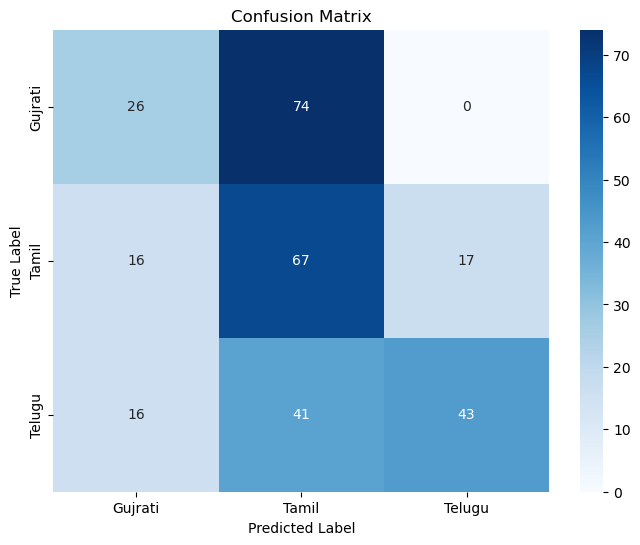

Overall Accuracy: 45.33%


In [36]:
confusion_matrix = np.zeros((3, 3))  # 3 classes: Gujrati, Tamil, Telugu

for idx, path in enumerate(test_paths):
    # Initialize counters for each class
    class_counts = {0: 0, 1: 0, 2: 0}
    for root, _, files in os.walk(path):
        for file in files:
            vote = np.zeros(3)
            for i in range(len(Ensembled_gmms)):
                voteclass, weight = Ensembled_gmms[i].ensembled_vote(root+'/'+file, 'acc')
            vote[voteclass] += weight
            winner = np.argmax(vote)
            class_counts[winner] += 1  # Increment the count for the winner class
        print(path)
    # Update confusion matrix
    for true_label, count in class_counts.items():
        confusion_matrix[idx, true_label] = count

    # Define class labels
class_labels = ['Gujrati', 'Tamil', 'Telugu']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
print(f"Overall Accuracy: {accuracy*100:.2f}%")
